In [1]:
#Imports
import numpy as np
import wandb
import matplotlib.pyplot as plt


In [2]:
#Relevant Sweeps
api = wandb.Api()

BP_Cifar10 = api.sweep("brai-lab/MetaWP/rdlxynh1")
BP_Mnist = api.sweep("brai-lab/MetaWP/yeudfda9")
FFD_Mnist = api.sweep("brai-lab/MetaWP/pqgsrv6j")
FFD_Cifar10 = api.sweep("brai-lab/MetaWP/0jmmy50t")
CFD_Mnist = api.sweep("brai-lab/MetaWP/qzfa1v1l")
CFD_Cifar10 = api.sweep("brai-lab/MetaWP/hc97lew4")


In [3]:
def Nr_forward_passes(run, algorithm):
    num_perts = run.config.get("num_perts")
    if algorithm.lower() == "forw" or algorithm.lower() == "ffd":
        Num_passes = num_perts + 1
    elif algorithm.lower() == "cent" or algorithm.lower() == "cfd":
        Num_passes = num_perts * 2
    return Num_passes

In [4]:
def get_metrics(sweep):
    sweep_runs = sweep.runs
    algorithm = sweep_runs[0].config.get("algorithm")
    Num_passes = np.zeros((len(sweep_runs)))

    loss = np.zeros( (len(sweep_runs), 499))
    acc = np.zeros((len(sweep_runs), 499))
    angle = np.zeros((len(sweep_runs), 499))
    ose = np.zeros((len(sweep_runs), 499))
    for i, run in enumerate(sweep_runs):

        history = run.history(pandas=False)
        # .history apparently does not return things in chronological order https://github.com/wandb/wandb/issues/5219
        for n, epoch in enumerate(history[:499]):
            if(n == 499):
                print(epoch)
            loss[i, n] = epoch['test/loss']
            acc[i, n] = epoch["test/acc"] 

            if(algorithm.lower() != "bp"):
                ose[i, n] = epoch["angle/angle"] 
                angle[i, n] = epoch["angle/OSE"]
        Num_passes[i] = Nr_forward_passes(run, algorithm) if (algorithm.lower() != "bp") else 1
    return loss, acc, angle, ose, Num_passes

In [40]:
def make_boxplots(FFD_stats, CFD_stats, BP_stats, task):

    cfd_acc = np.split(np.flip(CFD_stats[1][:, -1]), 3)
    cfd_loss = np.split(np.flip(CFD_stats[0][:, -1]), 3)
    ffd_acc = np.split(np.flip(FFD_stats[1][:, -1]), 3)
    ffd_loss = np.split(np.flip(FFD_stats[0][:, -1]), 3)

    accs = [BP_stats[1][:, -1]]
    losses = [BP_stats[0][:, -1]]
    labels = ["(BP) " + str(1)]

    CFD_num_passes = np.unique(CFD_stats[4])
    FFD_num_passes = np.unique(FFD_stats[4])

    for i in range(3):
        labels.append("(FFD) " + str(int(FFD_num_passes[i])))

        labels.append("(CFD) " + str(int(CFD_num_passes[i])))
        accs.append(ffd_acc[i])
        accs.append(cfd_acc[i])
        losses.append(ffd_loss[i])
        losses.append(cfd_loss[i])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    ax1.set_title(f"Accuracy vs number of forward passes on {task}")
    ax1.set_ylabel("Accuracy (test set)")

    ax1.set_xlabel("Nr. forward passes")
    ax1.boxplot(accs, tick_labels=labels)

    ax2.set_title(f"Loss vs number of forward passes on {task}")
    ax2.set_ylabel("Loss (test set)")

    ax2.set_xlabel("Nr. forward passes")
    ax2.boxplot(losses, tick_labels=labels)

    plt.show()    

In [35]:
FFD_CIFAR10_stats = get_metrics(FFD_Cifar10)
CFD_CIFAR10_stats = get_metrics(CFD_Cifar10)
BP_CIFAR10_stats = get_metrics(BP_Cifar10)

FFD_MNIST_stats = get_metrics(FFD_Mnist)
CFD_MNIST_stats = get_metrics(CFD_Mnist)
BP_MNIST_stats = get_metrics(BP_Mnist)

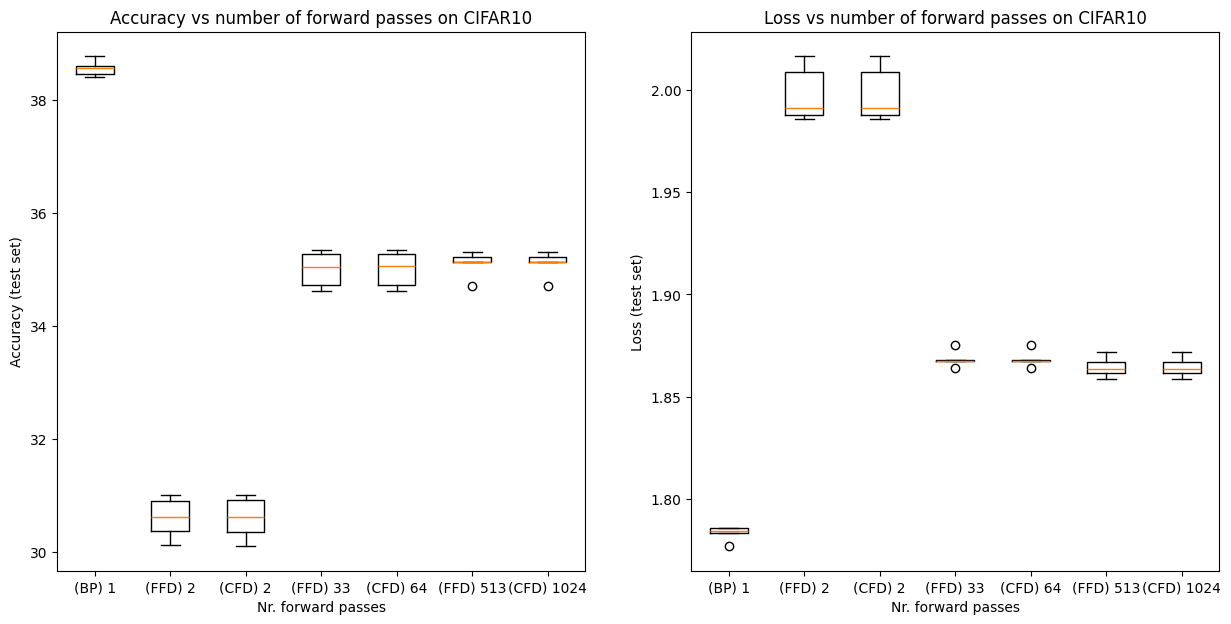

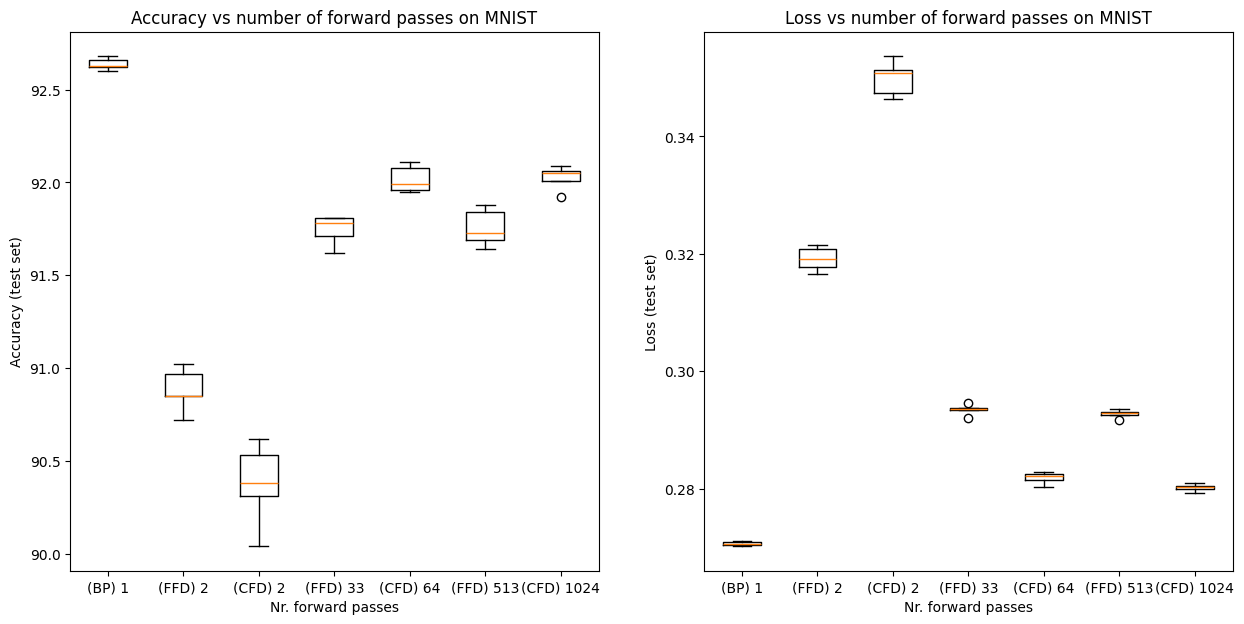

In [41]:
make_boxplots(FFD_CIFAR10_stats, CFD_CIFAR10_stats, BP_CIFAR10_stats, "CIFAR10")
make_boxplots(FFD_MNIST_stats, CFD_MNIST_stats, BP_MNIST_stats, "MNIST")

# very surprising that they should be so similar, but it is the case:
# https://wandb.ai/brai-lab/MetaWP/runs/18y6z1jh/logs - ffd
# https://wandb.ai/brai-lab/MetaWP/runs/eh2isu8h/logs - cfd - in the last epoch, the loss is only smaller by 1e-7